In [65]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from natsort import natsorted
import time
#uninstall opencv-python and install opencv-contrib-python, also install natsorted

In [66]:
def modify_intensity(image, alpha, beta):
    modified_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return modified_image

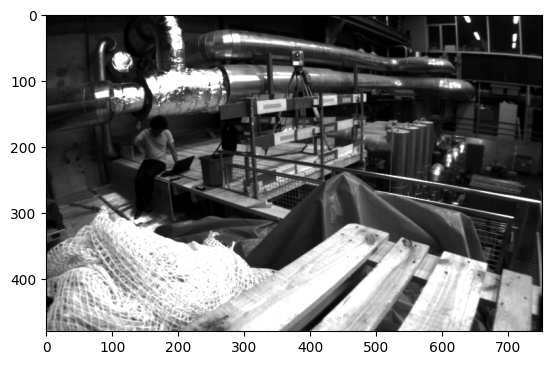

In [67]:
img1 = cv2.imread('../data/MH_02/1403636579763555584.png', cv2.IMREAD_GRAYSCALE)
img2 = modify_intensity(img1, alpha=1, beta=-50)
plt.imshow(img1, cmap='gray')

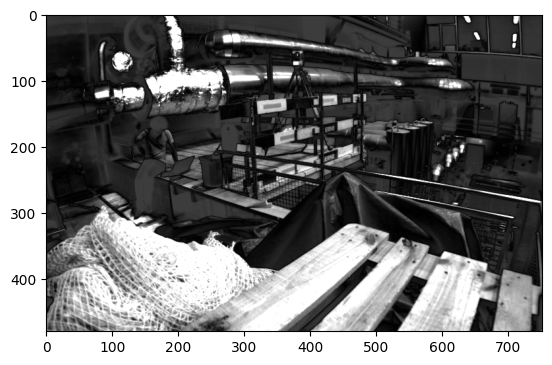

In [68]:
plt.imshow(img2, cmap='gray')

In [69]:
# with Ransac
import cv2
import numpy as np


def modify_intensity(image, alpha, beta):
    modified_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return modified_image


def find_correspondences(image1, image2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    gray2 = modify_intensity(gray2, alpha=0.2, beta=0)
    # plt.imshow(gray1, cmap='gray')
    # plt.imshow(gray2, cmap='gray')

    # fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    # axes[0].imshow(gray1, cmap='gray')
    # # axes[0].set_title('All Correspondences')
    # axes[1].imshow(gray2, cmap='gray')
    # # axes[1].set_title('Inliers Correspondences')
    # # axes[2].imshow(outliers_correspondence_img)
    # plt.show()

    # Create FAST detector
    fast = cv2.FastFeatureDetector_create()

    # Detect keypoints in both images
    keypoints1 = fast.detect(gray1, None)
    keypoints2 = fast.detect(gray2, None)

    # Create BRIEF extractor
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

    # Compute descriptors for keypoints in both images
    keypoints1, descriptors1 = brief.compute(gray1, keypoints1)
    keypoints2, descriptors2 = brief.compute(gray2, keypoints2)

    # Match descriptors using a feature matching algorithm (e.g., Brute-Force matcher)
    bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf_matcher.match(descriptors1, descriptors2)

    # Sort matches based on their distance (lower is better)
    matches = sorted(matches, key=lambda x: x.distance)

    # Find successful and failed correspondences
    successful_matches = [
        match for match in matches if match.distance < 50
    ]  # Adjust the distance threshold as needed
    failed_matches = [
        match for match in matches if match.distance >= 50
    ]  # Adjust the distance threshold as needed

    # Extract the matched keypoints' locations
    src_pts = np.float32(
        [keypoints1[m.queryIdx].pt for m in successful_matches]
    ).reshape(-1, 1, 2)
    dst_pts = np.float32(
        [keypoints2[m.trainIdx].pt for m in successful_matches]
    ).reshape(-1, 1, 2)

    # Apply RANSAC to find inliers and outliers
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Extract the inliers and outliers
    inliers = [successful_matches[i] for i in range(len(successful_matches)) if mask[i]]
    outliers = [
        successful_matches[i] for i in range(len(successful_matches)) if not mask[i]
    ]

    print(
        "Fast Brief correspondance",
        len(successful_matches),
        "inliers",
        len(inliers),
        "outliers",
        len(outliers),
    )
    # Draw correspondences and highlight inliers and outliers on the images
    correspondence_img = cv2.drawMatches(
        image1,
        keypoints1,
        gray2,
        keypoints2,
        successful_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    inliers_correspondence_img = cv2.drawMatches(
        image1,
        keypoints1,
        gray2,
        keypoints2,
        inliers,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchColor=(0, 255, 0),
    )
    outliers_correspondence_img = cv2.drawMatches(
        image1,
        keypoints1,
        gray2,
        keypoints2,
        outliers,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchColor=(0, 0, 255),
    )

    return correspondence_img, inliers_correspondence_img, outliers_correspondence_img


if __name__ == "__main__":
    # Load two images
    image1 = cv2.imread("../data/MH_02/1403636651213555456.png")
    image2 = cv2.imread("../data/MH_02/1403636650663555584.png")

    # Find correspondences and display images
    (
        correspondence_img,
        inliers_correspondence_img,
        outliers_correspondence_img,
    ) = find_correspondences(image1, image2)

    # Display the images
    cv2.imshow("Correspondences", correspondence_img)
    cv2.imshow("Inliers Correspondences", inliers_correspondence_img)
    cv2.imshow("Outliers Correspondences", outliers_correspondence_img)
    cv2.imwrite(
        "../results_data/DRDO/fast_brief_correspondance.png", correspondence_img
    )
    cv2.imwrite(
        "../results_data/DRDO/fast_breif_inlier_correspondance.png",
        inliers_correspondence_img,
    )
    cv2.imwrite(
        "../results_data/DRDO/fast_breif_outlier_correspondance.png",
        outliers_correspondence_img,
    )
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Fast Brief correspondance 359 inliers 308 outliers 51


In [70]:
import cv2
import numpy as np


def modify_intensity(image, alpha, beta):
    modified_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return modified_image


def find_correspondences(image1, image2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    gray2 = modify_intensity(gray2, alpha=0.2, beta=0)

    # Create SIFT detector and descriptor extractor
    sift = cv2.SIFT_create()

    # Detect keypoints in both images
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # Match descriptors using a feature matching algorithm (e.g., Brute-Force matcher)
    bf_matcher = cv2.BFMatcher()
    matches = bf_matcher.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to filter out bad matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Extract the matched keypoints' locations
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(
        -1, 1, 2
    )
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(
        -1, 1, 2
    )

    # Apply RANSAC to find inliers and outliers
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Extract the inliers and outliers
    inliers = [good_matches[i] for i in range(len(good_matches)) if mask[i]]
    outliers = [good_matches[i] for i in range(len(good_matches)) if not mask[i]]

    print(
        "Sift correspondance",
        len(good_matches),
        "inliers",
        len(inliers),
        "outliers",
        len(outliers),
    )

    # Draw correspondences and highlight inliers and outliers on the images
    correspondence_img = cv2.drawMatches(
        image1,
        keypoints1,
        gray2,
        keypoints2,
        good_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    inliers_correspondence_img = cv2.drawMatches(
        image1,
        keypoints1,
        gray2,
        keypoints2,
        inliers,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchColor=(0, 255, 0),
    )
    outliers_correspondence_img = cv2.drawMatches(
        image1,
        keypoints1,
        gray2,
        keypoints2,
        outliers,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchColor=(0, 0, 255),
    )

    return correspondence_img, inliers_correspondence_img, outliers_correspondence_img


if __name__ == "__main__":
    # Load two images
    image1 = cv2.imread("../data/MH_02/1403636651213555456.png")
    image2 = cv2.imread("../data/MH_02/1403636650663555584.png")

    # Find correspondences and display images
    (
        correspondence_img,
        inliers_correspondence_img,
        outliers_correspondence_img,
    ) = find_correspondences(image1, image2)

    # Display the images
    cv2.imshow("Correspondences", correspondence_img)
    cv2.imshow("Inliers Correspondences", inliers_correspondence_img)
    cv2.imshow("Outliers Correspondences", outliers_correspondence_img)
    cv2.imwrite("../results_data/DRDO/sift_correspondance.png", correspondence_img)
    cv2.imwrite(
        "../results_data/DRDO/sift_inlier_correspondance.png",
        inliers_correspondence_img,
    )
    cv2.imwrite(
        "../results_data/DRDO/sift_outlier_correspondance.png",
        outliers_correspondence_img,
    )
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Sift correspondance 108 inliers 93 outliers 15


In [71]:
import cv2
import numpy as np


def modify_intensity(image, alpha, beta):
    modified_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return modified_image


def find_correspondences(image1, image2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    gray2 = modify_intensity(gray2, alpha=-0.2, beta=0)

    # Create Orb detector and descriptor extractor
    orb = cv2.ORB_create()

    # Detect keypoints in both images
    keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

    # Match descriptors using a feature matching algorithm (e.g., Brute-Force matcher)
    bf_matcher = cv2.BFMatcher()
    matches = bf_matcher.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to filter out bad matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Extract the matched keypoints' locations
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(
        -1, 1, 2
    )
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(
        -1, 1, 2
    )

    # Apply RANSAC to find inliers and outliers
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Extract the inliers and outliers
    inliers = [good_matches[i] for i in range(len(good_matches)) if mask[i]]
    outliers = [good_matches[i] for i in range(len(good_matches)) if not mask[i]]

    print(
        "Orb correspondance",
        len(good_matches),
        "inliers",
        len(inliers),
        "outliers",
        len(outliers),
    )

    # Draw correspondences and highlight inliers and outliers on the images
    correspondence_img = cv2.drawMatches(
        image1,
        keypoints1,
        gray2,
        keypoints2,
        good_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    inliers_correspondence_img = cv2.drawMatches(
        image1,
        keypoints1,
        gray2,
        keypoints2,
        inliers,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchColor=(0, 255, 0),
    )
    outliers_correspondence_img = cv2.drawMatches(
        image1,
        keypoints1,
        gray2,
        keypoints2,
        outliers,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchColor=(0, 0, 255),
    )

    return correspondence_img, inliers_correspondence_img, outliers_correspondence_img


if __name__ == "__main__":
    # Load two images
    image1 = cv2.imread("../data/MH_02/1403636651213555456.png")
    image2 = cv2.imread("../data/MH_02/1403636650663555584.png")

    # Find correspondences and display images
    (
        correspondence_img,
        inliers_correspondence_img,
        outliers_correspondence_img,
    ) = find_correspondences(image1, image2)

    # Display the images
    cv2.imshow("Correspondences", correspondence_img)
    cv2.imshow("Inliers Correspondences", inliers_correspondence_img)
    cv2.imshow("Outliers Correspondences", outliers_correspondence_img)
    cv2.imwrite("../results_data/DRDO/orb_correspondance.png", correspondence_img)
    cv2.imwrite(
        "../results_data/DRDO/orb_inlier_correspondance.png", inliers_correspondence_img
    )
    cv2.imwrite(
        "../results_data/DRDO/orb_outlier_correspondance.png",
        outliers_correspondence_img,
    )
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Orb correspondance 108 inliers 105 outliers 3
